issues:
- abcd's still seem a liiiittle bit off..
- divide cavities.py into sub-files?
- abcd aspheres with quadratic term
- get working with mirror designs so we can compare, e.g., with SyntheticLandauLevels

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib widget
#from ipywidgets import *
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.tools import *
from sloppy.abcd import *
from sloppy.utils import *

In [3]:
import sys
sys.path.append('../')
from cavities import *

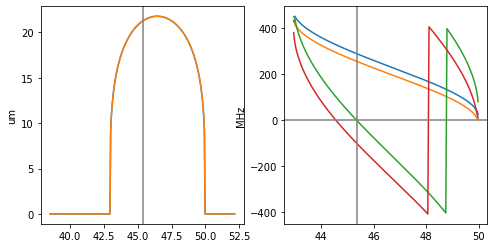

In [4]:
waists_vs_param(Cav1L2Q, 'lens_dist', 1.5e-1)
plt.show()

In [16]:
# elements = Cav1L2Q()
# elements[-1].n=elements[0].n
# sys = RaySystem(elements)
# mu = np.array([0., 0., 0., 0.])
# ray = sys.screen.eigenvectors_to_rays(mu)

# try:
#     plot.close()
# except:
#     pass
# plot = k3d.plot(camera_auto_fit=True, antialias=True)

# for i, el in enumerate(sys.elements):
#     plot += el.plot(opacity=0.4)

# for i, el in enumerate(sys.elements):
#     plot_element_ax(el, plot, length=5.)

# plot_rays(ray, plot)
# plot.display()

waist = 21.2 um


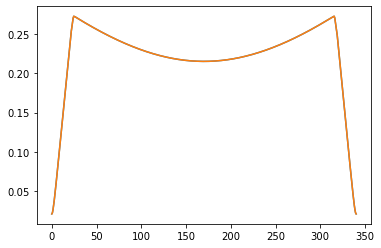

In [7]:
res = degeneracy_length(Cav1L2Q, 'lens_dist', 1e-1)
Ldeg = res.x
elements = Cav1L2Q(lens_dist=Ldeg)
syst = RaySystem(elements)
system = syst.abcd
system.waist_at(0)
x = np.linspace(0, system.Ltot, 500)
ws = system.compute_waists(x)
waist0 = np.min(ws)
print(f"waist = {waist0*1000:.1f} um")
plt.figure()
plt.plot(x, ws)
plt.show()

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharex='row', sharey='row')
ms = 8.
lines = [a.scatter([], [], c=[], cmap='winter_r', s=ms) for a in ax.flatten()]
ax[0].set_title('Raytracing')
ax[1].set_title('ABCD')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
 
cavfct = Cav1L2Q
parname = 'lens_dist'
res = degeneracy_length(cavfct, parname, 1e-2)
Ldeg = res.x
#print(res)

def makeidx(hit_m):
    return np.arange(hit_m.shape[0])

def update(dl=0., c4=0., ar=0.0, br=0.0, ap=0., bp=0., Nrt=500, **kwargs):
        elements = cavfct(**{parname: Ldeg+dl*1e-1, 'c4': c4*1e-3})
        syst = RaySystem(elements)
        system = syst.abcd
        mu1, mu2 = system.q
        waist = waist0
        rmu1 = np.linalg.norm(np.real(mu1[:2]))
        rmu2 = np.linalg.norm(np.real(mu2[:2]))
        mu = np.real(ar*waist/rmu1*mu1*np.exp(1j*ap) + br*waist/rmu2*mu2*np.exp(1j*bp))
        
        #mu = np.real(ar*np.exp(1j*ap)*mu1 + br*np.exp(1j*bp)*mu2)
        ray0 = syst.screen.eigenvectors_to_rays(mu)
 
        traj_hit = syst.propagate(ray0, Nrt=Nrt, at_screen=True)
        hit_scr = syst.screen.r_to_screen_coords(traj_hit[:,0,0,:])
        hit_scrs = syst.screen.s_to_screen_coords(traj_hit[:,1,0,:])

        lines[0].set_offsets(hit_scr[:,:])
        lines[0].set_array(makeidx(hit_scr))
        
        hit_m = propagate_ABCD(mu, system.abcd_rt, Nrt=Nrt)
        lines[1].set_offsets(hit_m[:,0:2])
        lines[1].set_array(makeidx(hit_m))
        
        for l in lines:
            l.set_clim(vmin=0, vmax=Nrt)
            
        ax[0].set_xlim(1.5*np.nanmin(hit_scr[:,0]), 1.5*np.nanmax(hit_scr[:,0]))
        ax[0].set_ylim(1.5*np.nanmin(hit_scr[:,1]), 1.5*np.nanmax(hit_scr[:,1]))
        fig.canvas.draw_idle()
        
lo = Layout(width='80%', height='30px')
dls = FloatSlider(value=0., min=-10., max=1., step=1e-3, readout_format='.3f', layout=lo)
ars = FloatSlider(value=0., min=0., max=6., step=1e-2, readout_format='.3f', layout=lo)
brs = FloatSlider(value=0.1, min=0., max=6., step=1e-2, readout_format='.3f', layout=lo)
aps = FloatSlider(value=0., min=0., max=1*np.pi, step=1e-2, readout_format='.3f', layout=lo)
bps = FloatSlider(value=0., min=0., max=1*np.pi, step=1e-2, readout_format='.3f', layout=lo)
Nrts = IntSlider(value=100, min=100, max=2000, step=100, layout=lo)
c4s = FloatSlider(value=0.650, min=0., max=1.000, step=1e-4, readout_format='.6f', layout=lo)
#interactive(update, dl=(-10, 1, 1e-3), ar = (0,0.1,1e-3), br = (0,0.5,1e-3), ap= (0,2*np.pi,1e-2), bp= (0,2*np.pi,1e-2), Nrt=(0,2000,100))
interactive(update, dl=dls, c4=c4s, ar = ars, br = brs, ap= aps, bp= bps, Nrt=Nrts)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', layout=Layout(height='30px', width='80%'), max=…

In [36]:
def degeneracy_length_ray(cavfct, parname, r=0, scanrange=1e-3, La=None, c4=0.):
    def get_dev(l, r, c):
        elements = cavfct(**{parname: l, 'c4': c})
        sys = RaySystem(elements)
        system = sys.abcd
        mu1, mu2 = system.q
        waist = waist0 #system.waist_at(0)[0] FIX
        rmu = np.linalg.norm(np.real(mu2[:2]))
        mu = np.real(r*waist/rmu*mu2)#np.real(r*mu2)
        ray0 = sys.screen.eigenvectors_to_rays(mu)
        traj_hit = sys.propagate(ray0, Nrt=30, at_screen=True)
        hit_scr = sys.screen.r_to_screen_coords(traj_hit[:,0,0,:])
        hit_1 = hit_scr[::3,:]
        return np.var(hit_1, axis=0).sum()
    if La is None:
        La = inspect.signature(cavfct).parameters[parname].default
    res = minimize_scalar(get_dev, bounds=((1-scanrange)*La, (1+scanrange)*La), args=(r, c4), method='bounded')
    return res

In [45]:
rs = np.linspace(np.finfo(np.float32).resolution,8., 100)
Ls = np.zeros_like(rs)
lcur = Ldeg
for i, r in enumerate(rs):
    try:
        l = degeneracy_length_ray(cavfct, parname, r=r, scanrange=1e-2, La=lcur, c4=0.000077).x
    except:
        Ls[i] = np.nan
    else:
        Ls[i] = l
        lcur = l

In [46]:
plt.figure()
plt.plot(rs, Ls)
plt.title('Degeneracy length vs radius')
plt.xlabel(r'$r_{in}$ [waists]')
plt.ylabel(r'$L_{deg}$ [mm]')
plt.axhline(Ldeg, color='grey')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

issues fixed:
- fsr accounting for increased optical thickness of glass elements
- wrap guoy phase around fsr properly
- mode size in freeform surface index correction
- added proper cavity-stability boolean as property of ABCDSystem class
- handle improper values from unstable cavities better in plotting mode waist and guoy phases